In [3]:
%matplotlib inline
import numpy as np

## CT, SOFT TISSUE NECK

In [40]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
from skimage.draw import polygon

In [41]:
def read_structure(structure):
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        contour = {}
        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber ##
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
    return contours

def get_mask(contours, slices):
    z = [round(s.ImagePositionPatient[2],1) for s in slices] ##
    #print(z)
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    for con in contours:
        num = int(con['number'])
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3)) #triplets describing points of contour
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(np.around(nodes[0, 2], 1))
            #print(np.around(nodes[0, 2], 1))
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num

        colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors


In [71]:
train_data_path = 'C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/'

train_patients = [os.path.join(train_data_path, name) 
                    for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]

In [85]:
##lettura con ordinamento cartelle

patient = train_patients[6] ##sample patient
print(patient)


for dirs, subdir, files in os.walk(patient):
    ordered_subdirs = sorted(subdir, key=lambda x: len(os.listdir(os.path.join(dirs, x))))
    ordered_subdirs = [os.path.join(dirs, subdirname) for subdirname in ordered_subdirs]
    for subdirname in ordered_subdirs:
        if any('.dcm' in elem for elem in os.listdir(subdirname)) and len(os.listdir(subdirname))==1:
            structure = dicom.read_file(os.path.join(subdirname, os.listdir(subdirname)[0]))
            contours = read_structure(structure)
        elif any('.dcm' in elem for elem in os.listdir(subdirname)) and len(os.listdir(subdirname))>1:
            dcms = [os.path.join(subdirname, dcm) for dcm in os.listdir(subdirname)]
            slices = [dicom.read_file(dcm) for dcm in dcms]
            slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
            image = np.stack([s.pixel_array for s in slices], axis=-1)
            label, colors = get_mask(contours, slices)

C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0221


(-0.5, 511.5, 511.5, -0.5)

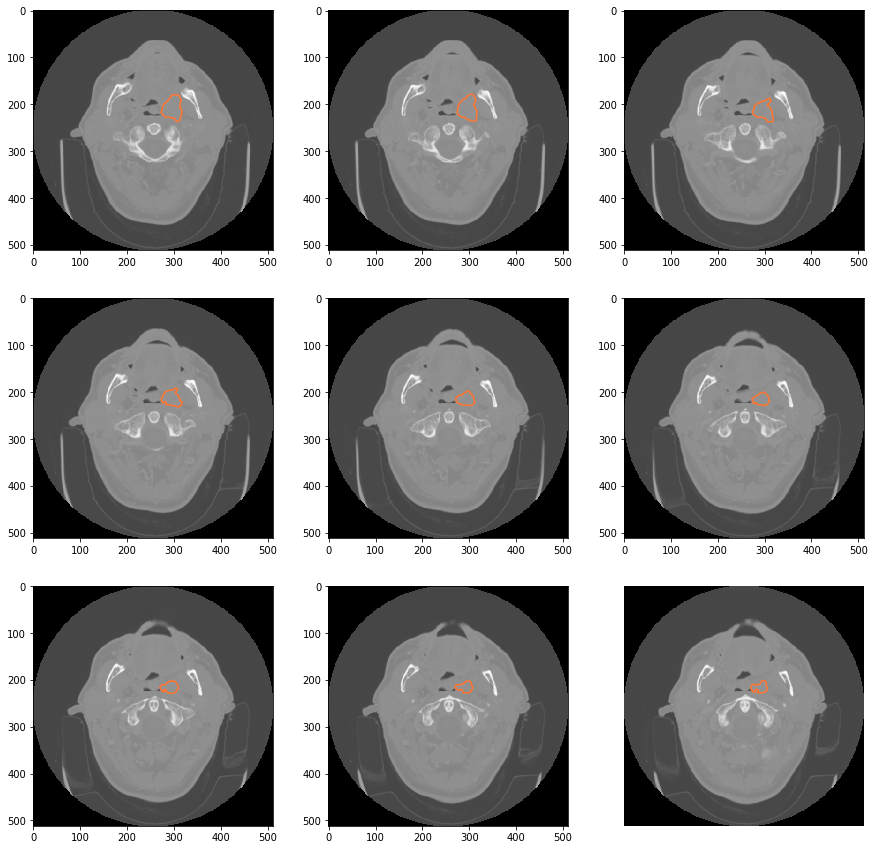

In [96]:
# Plot to check slices, for example 50 to 59

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    print(image[..., i + 200 ])
    plt.imshow(image[..., i + 200 ], cmap="gray")
    plt.contour(label[..., i + 200 ], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.axis('off')

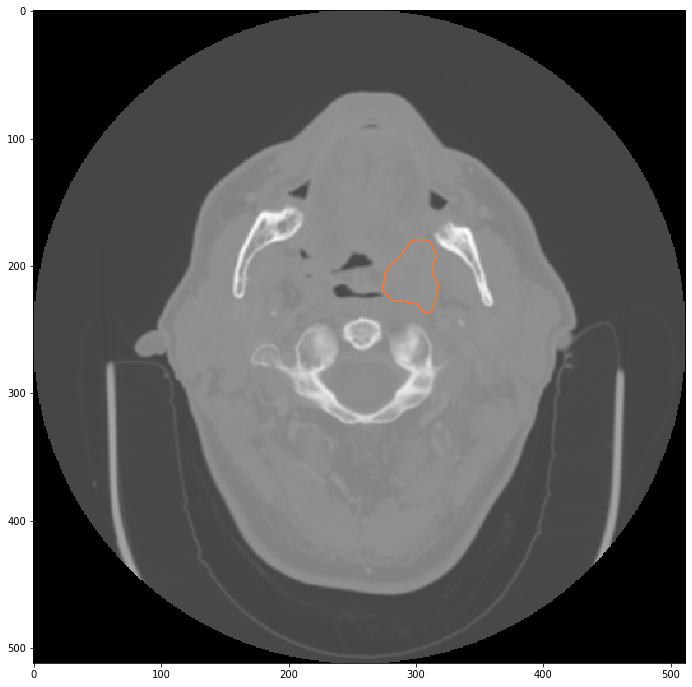

In [103]:
target_img = image[..., 200]
target_label = label[..., 200]
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(target_img, cmap="gray")
plt.contour(target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.show()

In [106]:
np.unique(target_label)

array([0, 1], dtype=uint8)